Compare the downstream cellchat output of the covid balf dataset, rather than just the embedding to get a better sense of the actual mechanistic differences in outputs. Focus on the "functional" analysis type. 

env: liana

In [1]:
suppressPackageStartupMessages({
    library(CellChat, quietly = T)
    library(patchwork, quietly = T)
    library(RhpcBLASctl, quietly = T)
    library(Matrix, quietly = T)
    library(data.table, quietly = T)
    library(ggplot2, quietly = T)
})
options(stringsAsFactors = FALSE)
# RhpcBLASctl::blas_set_num_threads(25) # no multithreading

# paths
expression_data_path = '/data2/hratch/immune_CCI/covid/expression_data/covid_data/'#'/data2/eric/CCC-Benchmark/data/External/'
external_expression_path = F # set to T if using commented out path , small parsing differences

rev_path = '/data3/hratch/tc2c_analyses_1/natcomm_revisions/'
raw_counts_path<-'/data2/hratch/immune_CCI/covid/expression_data/covid_data/'

# parameters
type_<-'functional'#'structural'
group<-1
seed<-888
set.seed(seed)

if (external_expression_path){
    cell_grouper<-'cell_type'
}else{
    cell_grouper<-'celltype'
}

In [40]:
# get samples
samples<-c()
for (fn in list.files(raw_counts_path)){
    samples<-c(samples, strsplit(fn, '_')[[1]][[2]])
}
samples<-unique(samples)

# load the data
context.map<-list()
sample.expr<-list()
for (sample in samples){
    sample.expr[[sample]][['expr']] = read.csv(paste0(raw_counts_path, 'DGE_', sample, '_External_Tool.csv'), row.names = 1)
    
#     md = read.csv(paste0(raw_counts_path, 'Meta_', sample, '_External_Tool.csv'), row.names = 1)
#     md[['cell.id']]<-row.names(md)
    sample.expr[[sample]][['md']] = read.csv(paste0(raw_counts_path, 'Meta_', sample, '_External_Tool.csv'), row.names = 1)
    
    context = sample.expr[[sample]][['md']][1, 'group']
    sample.expr[[sample]][['context']] = context
    if (context %in% names(context.map)){
        context.map[[context]]<-c(context.map[[context]], sample)
    }else{
        context.map[[context]]<-c(sample)
    }
}

In [106]:
# merge samples from same context into one expression matrix
context.exprs<-list()
context.mds<-list()

for (context in names(context.map)){
    expr<-list()
    md<-list()
    features<-c()
    for (sample in context.map[[context]]){
        expr[[sample]]<-sample.expr[[sample]][['expr']]
        features<-c(features, rownames(expr[[sample]]))
        md[[sample]]<-sample.expr[[sample]][['md']]
    }
    features<-unique(features)
    expr<-lapply(expr, function(x) x[features, ])
    
    context.expr<-do.call("cbind", expr)
    context.md<-do.call('rbind', md)
#     rownames(context.md)<-context.md$cell.id
    
    context.exprs[[context]]<-context.expr
    context.mds[[context]]<-context.md
}

In [ ]:
run_cellchat<-function(expr, md){
    expr<-CellChat::normalizeData(expr)
    cellchat<-createCellChat(object = as(expr, "dgCMatrix"), meta = md[colnames(expr),], 
                                   group.by = cell_grouper)
    cellchat@DB <- CellChatDB.human # human
    
    cellchat <- subsetData(cellchat)
    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <-identifyOverExpressedInteractions(cellchat)
    cellchat <- projectData(cellchat, PPI.human)
    
    cellchat <- computeCommunProb(cellchat, raw.use = F, type = 'triMean', trim = NULL, seed.use = seed, 
                                         population.size = T) 
    cellchat <- filterCommunication(cellchat, min.cells = 1) # as in liana
    cellchat <- computeCommunProbPathway(cellchat)
}

In [ ]:
cellchat.contexts<-list()
for (context in names(context.exprs)){
    print(context)
    cellchat.contexts[[context]]<-run_cellchat(expr = context.exprs[[context]], 
                                              md = context.mds[[context]])
}
saveRDS(cellchat.contexts, paste0(rev_path, 'interim/covid_balf_cellchat_grouped.rds'))


In [55]:
cellchat.contexts<-readRDS(paste0(rev_path, 'interim/covid_balf_cellchat_grouped.rds'))
covid<-mergeCellChat(cellchat.contexts, add.names = names(cellchat.contexts))

Merge the following slots: 'data.signaling','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



In [56]:
samples<-rep(NA, 3)
names(samples)<-c('HC', 'M', 'S')
comparisons<-sapply(names(samples), function(n) which(names(covid@net) == n))
combinations<-combn(comparisons, 2)
comparisons<-setNames(names(comparisons), comparisons)

In [63]:
theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
                 legend.text=element_text(size=25), legend.title=element_text(size=30), 
              axis.text.x = element_text(size = 25),axis.text.y = element_text(size = 25),
              plot.title = element_text(size = 30, hjust = 0.5))#, legend.position="none")
fig_no = c(11,12,13)
plots<-list()
for (col in (1:dim(combinations)[[2]])){
    comparison<-comparisons[as.character(combinations[,col])]
    res<-netVisual_bubble(covid,  comparison = as.numeric(names(comparison)), angle.x = 45, return.data=T)
    
    df<-res[[1]]
    write.csv(df, paste0(rev_path, 'supp_fig', fig_no[[col]], '_sourcedata.csv'))
    
    g<-res[[2]] + ggtitle(paste0(comparison, collapse = ' vs ')) + theme
    plots[[col]]<-g
}


Comparing communications on a merged object 


Comparing communications on a merged object 


Comparing communications on a merged object 




In [36]:
h_ = 49.5
w_ = 40
options(repr.plot.height=h_, repr.plot.width=w_)
for (i in 1:length(plots)){
    g<-plots[[i]]
    ggsave(paste0(rev_path, 'figures/cellchat_merged_bubbleplot_panel', i,'.pdf'), 
           g, height = h_, width = w_)
}
# g<-plots[[1]] + plots[[2]] + plots[[3]]
# ggsave(paste0(rev_path, 'figures/cellchat_merged_bubbleplot.pdf'), g, height = h_, width = w_)


In [4]:
# get UMAP
covid <- computeNetSimilarityPairwise(covid)
covid <- netEmbedding(covid, type = 'functional')
covid<-netClustering(covid, type = "functional")

Compute signaling network similarity for datasets 1 2 3 
Manifold learning of the signaling networks for datasets 1 2 3 
Classification learning of the signaling networks for datasets 1 2 3 


In [7]:
# #' 2D visualization of the joint manifold learning of signaling networks from two datasets
# #'
# #' @param object CellChat object
# #' @param slot.name the slot name of object that is used to compute centrality measures of signaling networks
# #' @param type "functional","structural"
# #' @param comparison a numerical vector giving the datasets for comparison. Default are all datasets when object is a merged object
# #' @param pathway.labeled a char vector giving the signaling names to show when labeling each point
# #' @param top.label the fraction of signaling pathways to label
# #' @param pathway.remove a character vector defining the signaling to remove
# #' @param pathway.remove.show whether show the removed signaling names
# #' @param color.use defining the color for each cell group
# #' @param point.shape a numeric vector giving the point shapes. By default point.shape <- c(21, 0, 24, 23, 25, 10, 12), see available shapes at http://www.sthda.com/english/wiki/r-plot-pch-symbols-the-different-point-shapes-available-in-r
# #' @param dot.size a range defining the size of the symbol
# #' @param dot.alpha transparency
# #' @param xlabel label of x-axis
# #' @param ylabel label of y-axis
# #' @param title main title of the plot
# #' @param label.size font size of the text
# #' @param do.label label the each point
# #' @param show.legend whether show the legend
# #' @param show.axes whether show the axes
# #' @import ggplot2
# #' @importFrom ggrepel geom_text_repel
# #' @importFrom methods slot
# #' @return
# #' @export
# #'
# #' @examples
# netVisual_embeddingPairwise_df <- function(object, slot.name = "netP", type = c("functional","structural"), comparison = NULL, color.use = NULL, point.shape = NULL, pathway.labeled = NULL, top.label = 1, pathway.remove = NULL, pathway.remove.show = TRUE, dot.size = c(2, 6), label.size = 2.5, dot.alpha = 0.5,
#                                         xlabel = "Dim 1", ylabel = "Dim 2", title = NULL,do.label = T, show.legend = T, show.axes = T) {
#   type <- match.arg(type)
#   if (is.null(comparison)) {
#     comparison <- 1:length(unique(object@meta$datasets))
#   }
#   cat("2D visualization of signaling networks from datasets", as.character(comparison), '\n')
#   comparison.name <- paste(comparison, collapse = "-")

#   Y <- methods::slot(object, slot.name)$similarity[[type]]$dr[[comparison.name]]
#   clusters <- methods::slot(object, slot.name)$similarity[[type]]$group[[comparison.name]]
#   object.names <- setdiff(names(methods::slot(object, slot.name)), "similarity")[comparison]
#   prob <- list()
#   for (i in 1:length(comparison)) {
#     object.net <- methods::slot(object, slot.name)[[comparison[i]]]
#     prob[[i]] = object.net$prob
#   }

#   if (is.null(point.shape)) {
#     point.shape <- c(21, 0, 24, 23, 25, 10, 12)
#   }

#   if (is.null(pathway.remove)) {
#     similarity <- methods::slot(object, slot.name)$similarity[[type]]$matrix[[comparison.name]]
#     pathway.remove <- rownames(similarity)[which(colSums(similarity) == 1)]
#     pathway.remove <- sub("--.*", "", pathway.remove)
#   }

#   if (length(pathway.remove) > 0) {
#     for (i in 1:length(prob)) {
#       probi <- prob[[i]]
#       pathway.remove.idx <- which(paste0(dimnames(probi)[[3]],"--",object.names[i]) %in% pathway.remove)
#     #  pathway.remove.idx <- which(dimnames(probi)[[3]] %in% pathway.remove)
#       if (length(pathway.remove.idx) > 0) {
#         probi <- probi[ , , -pathway.remove.idx]
#       }
#       prob[[i]] <- probi
#     }
#   }
#   prob_sum.each <- list()
#   signalingAll <- c()
#   for (i in 1:length(prob)) {
#     probi <- prob[[i]]
#     prob_sum.each[[i]] <- apply(probi, 3, sum)
#     signalingAll <- c(signalingAll, paste0(names(prob_sum.each[[i]]),"--",object.names[i]))
#   }
#   prob_sum <- unlist(prob_sum.each)
#   names(prob_sum) <- signalingAll

#   group <- sub(".*--", "", names(prob_sum))
#   labels = sub("--.*", "", names(prob_sum))

#   df <- data.frame(x = Y[,1], y = Y[, 2], Commun.Prob. = prob_sum/max(prob_sum),
#                    labels = as.character(labels), clusters = as.factor(clusters), group = factor(group, levels = unique(group)))
#   return(df)
# }
# df<-netVisual_embeddingPairwise_df(covid, type = "functional", label.size = 7.5, do.label=T)
# write.csv(df, paste0(rev_path, 'supp_fig10a_sourcedata.csv'))

2D visualization of signaling networks from datasets 1 2 3 


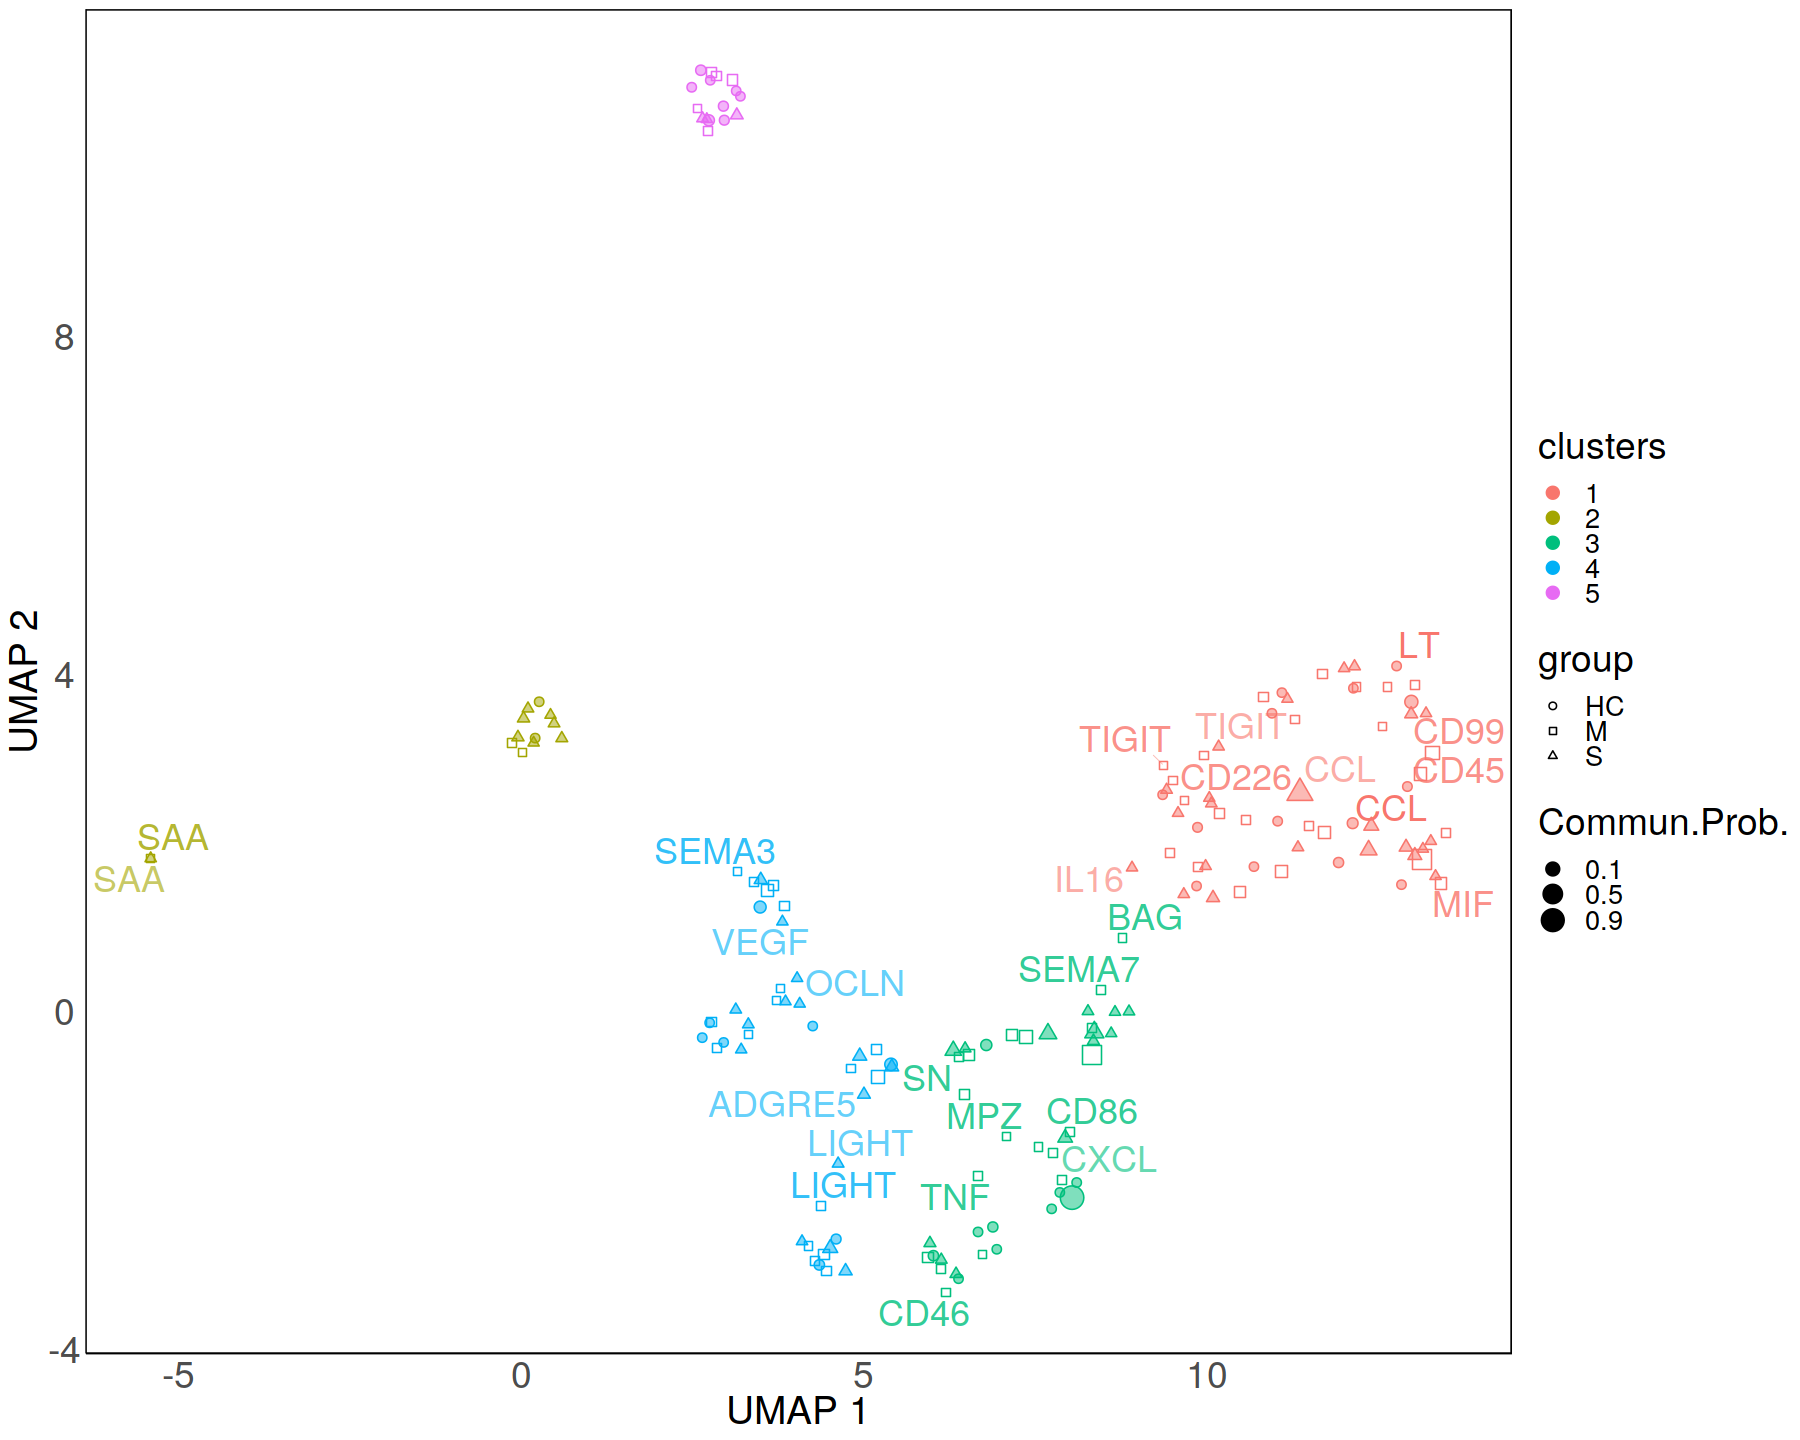

In [42]:
h_ = 12
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 22), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 22))

g<-netVisual_embeddingPairwise(covid, type = "functional", label.size = 7.5, do.label=T) + theme +
xlab("UMAP 1") + ylab("UMAP 2")

ggsave(paste0(rev_path, 'figures/cellchat_merged_umap.pdf'), g, height = h_, width = w_)
g

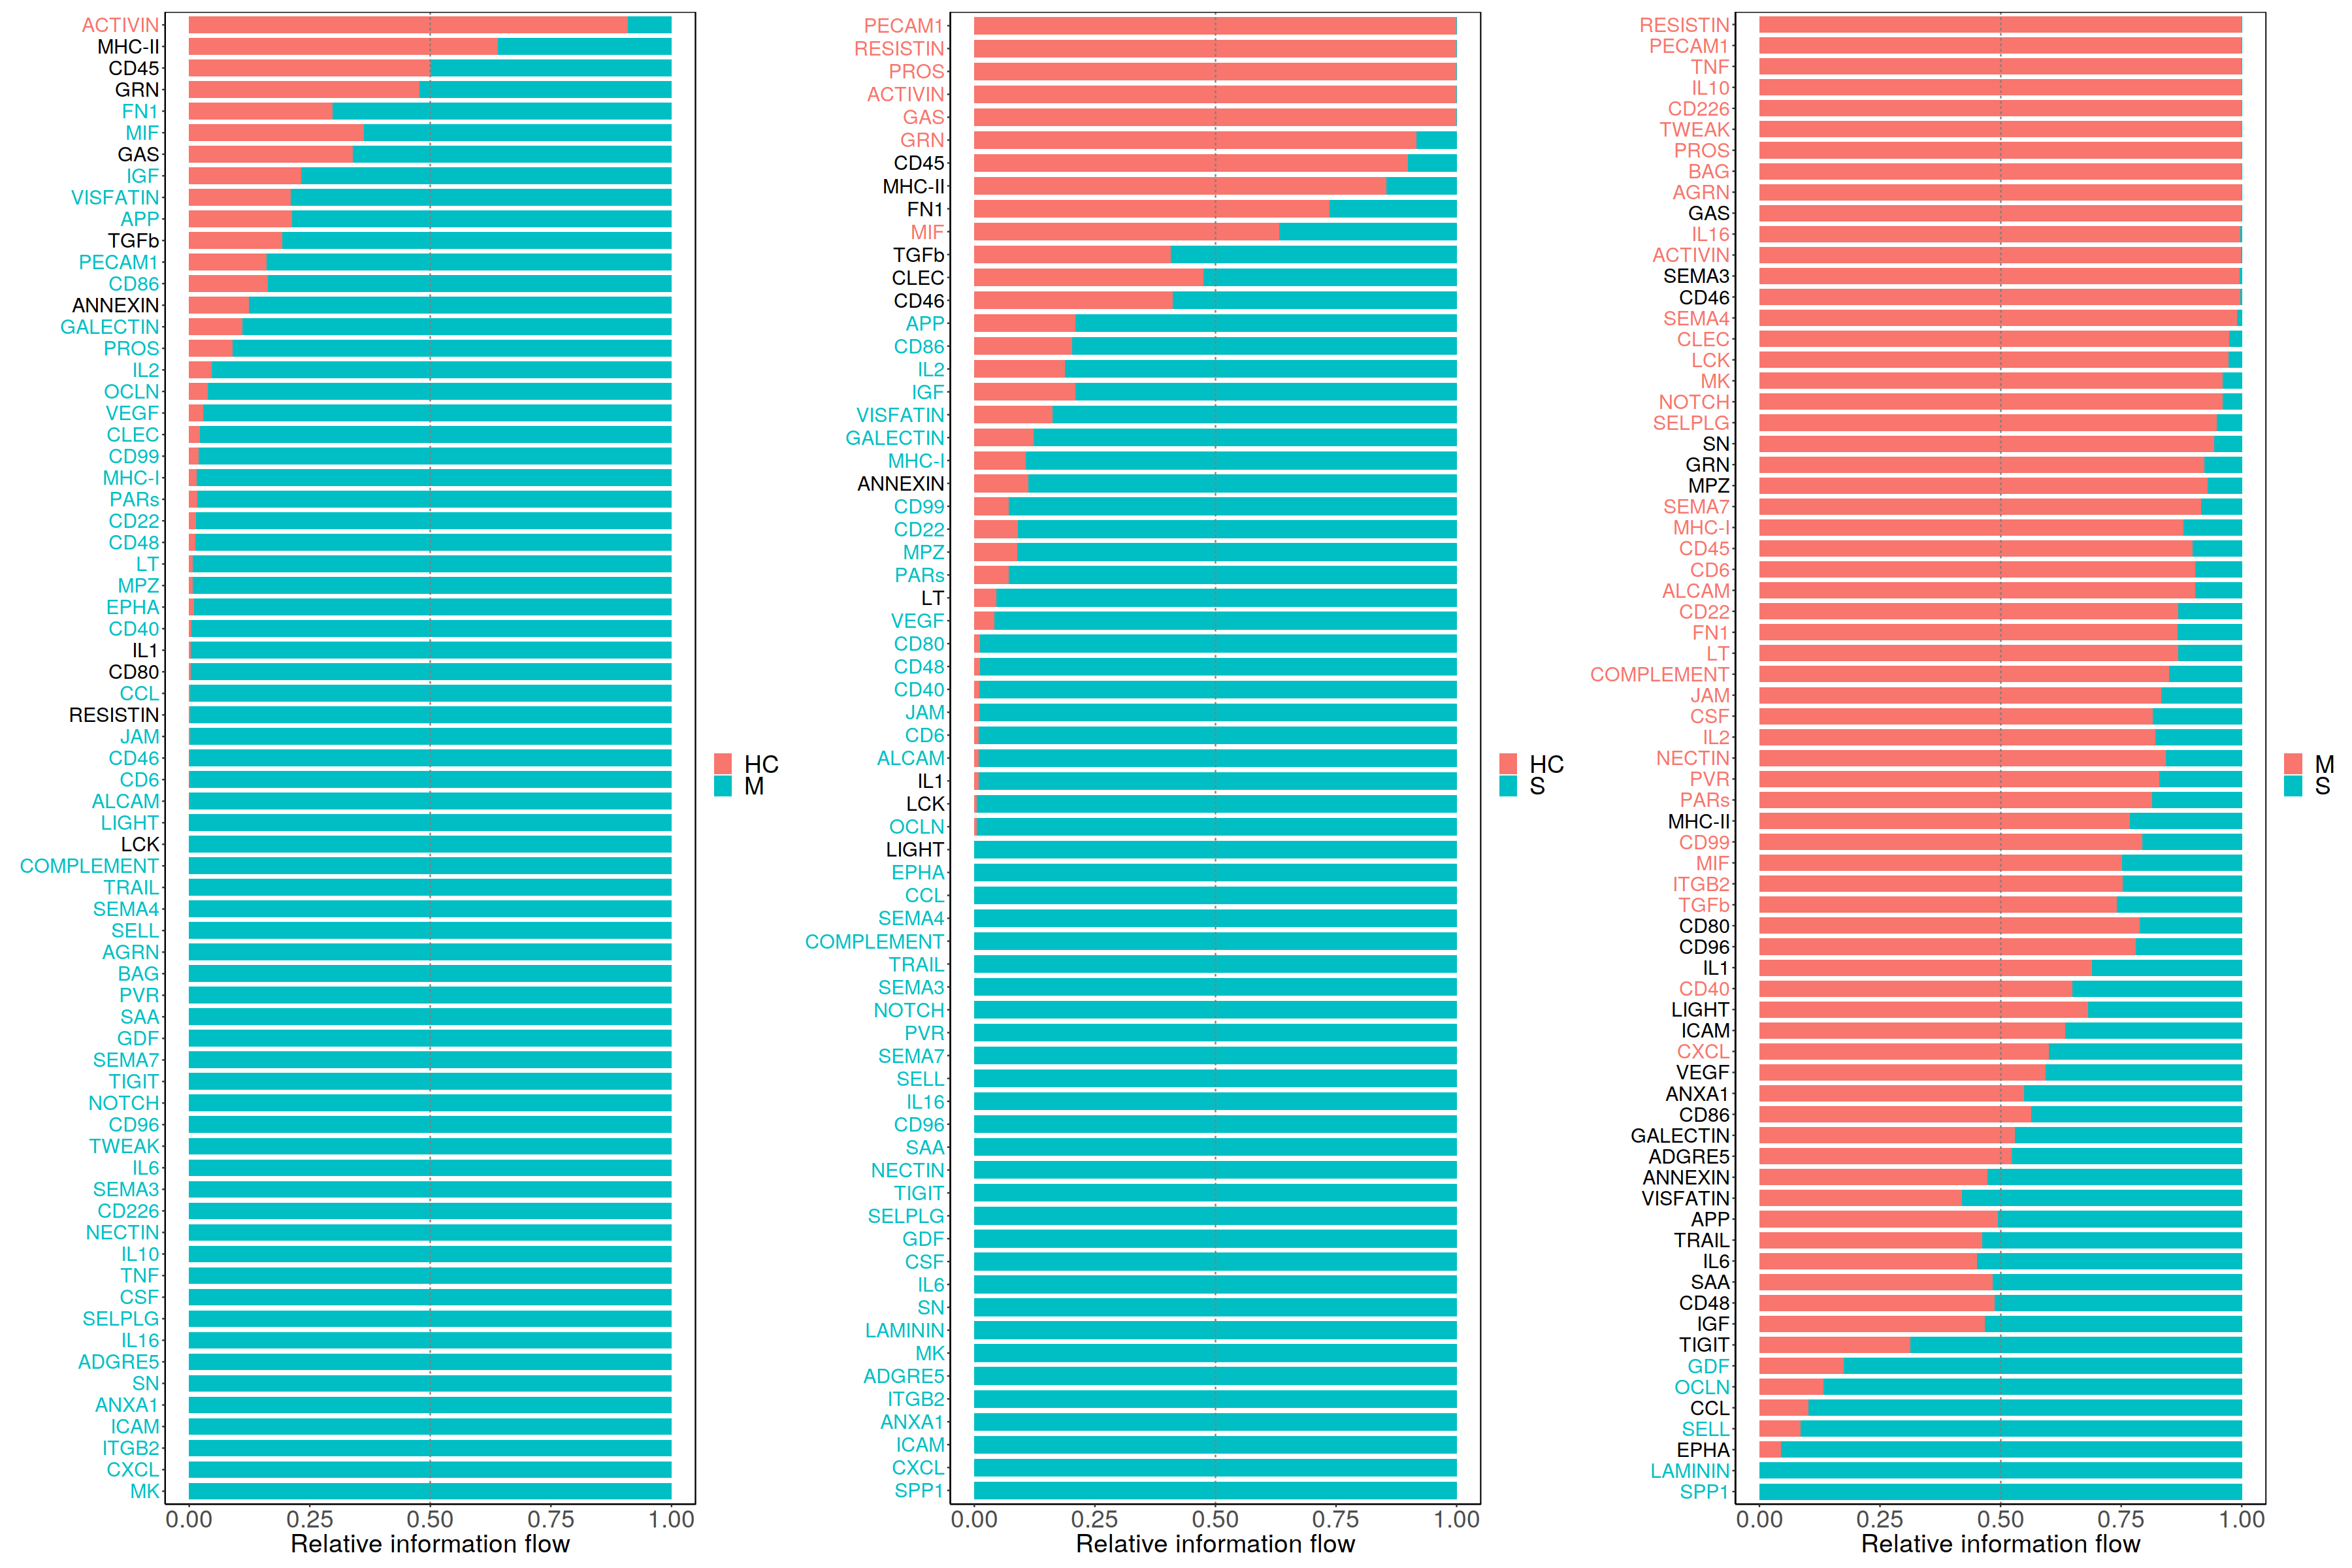

In [48]:
h_ = 20
w_ = 30
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
          axis.title=element_text(size=23), legend.text=element_text(size=22), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 22))

res1 <- rankNet(covid, mode = "comparison", comparison = c(1,2), return.data = T,
               stacked = T, do.stat = TRUE)
df1<-res[[1]]
gg1<-res[[2]]
df1[['Comparison']]<-paste0(names(covid@idents)[[1]], ' vs ', names(covid@idents)[[2]])

res2 <- rankNet(covid, mode = "comparison", comparison = c(1,3), return.data = T,
               stacked = T, do.stat = TRUE)
df2<-res[[1]]
gg2<-res[[2]]
df2[['Comparison']]<-paste0(names(covid@idents)[[1]], ' vs ', names(covid@idents)[[3]])


res3 <- rankNet(covid, mode = "comparison", comparison = c(2,3), return.data = T,
               stacked = T, do.stat = TRUE)
df3<-res[[1]]
gg3<-res[[2]]
df3[['Comparison']]<-paste0(names(covid@idents)[[2]], ' vs ', names(covid@idents)[[3]])

df<-rbind(df1, df2, df3)
rownames(df)<-1:dim(df)[[1]]
write.csv(df, paste0(rev_path, 'supp_fig10b_sourcedata.csv'))

gg1 <- gg1 + theme
gg2 <- gg2 + theme
gg3 <- gg3 + theme
g<-gg1+gg2+gg3
ggsave(paste0(rev_path, 'figures/cellchat_merged_informationflow.pdf'), g, height = h_, width = w_)
g

In [192]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/hratch/anaconda3/envs/cellchat/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SeuratObject_4.0.2   Seurat_4.0.3         data.table_1.14.0   
 [4] Matrix_1.3-4         RhpcBLASctl_0.20-137 patchwork_1.1.1     
 [7] CellChat_1.0.0       Biobase_2.52.0       BiocGenerics_0.38.0 
[10] ggplot2_3.3.5        igraph_1.2.6         dplyr_1.0.7         

loaded via a nam